# PCA Reduction for Macros

#### 0. Data Preparation

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()
print(df.columns.tolist())

['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'VIX', 'MOVE', 'LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'Bitcoin Price', 'GDP Monthly', 'vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']


## Using Monthly granularity

### Find the covariance matrix

In [5]:
import math

# 1. Choose macro variables of interest
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC']

# 2. Drop NA rows (remove any month with missing data)
macro_df = df[macro_list].dropna()
print("Shape after dropping NA:", macro_df.shape)  # should be (months, 8)

# 3. Transpose: rows = variables, columns = time (as in original SVD method)
data = macro_df.T.values
m, n = data.shape

Shape after dropping NA: (89, 8)


In [9]:
# 4. Covariance matrix
S = np.cov(data)
print("Covariance matrix S:\n", S)

# 5. Correlation matrix
print("Correlation matrix:\n", np.corrcoef(data))

# 6. Eigenvalues (for total variance)
eigvals = np.linalg.eigvals(S)
print("Eigenvalues of covariance matrix:\n", eigvals)
print("Total variance:", np.sum(eigvals))

# 7. Recentered data matrix B
recentered_data = (data - data.mean(axis=1).reshape(-1, 1)) / math.sqrt(n - 1)
print("Recentered data matrix B:\n", recentered_data)

# 8. SVD of transposed recentered data
u, s, Pt = np.linalg.svd(recentered_data.T)
P = Pt.T  # P contains eigenvectors (principal directions)

# 9. Transform data: PC scores
transformed_data = Pt @ data
print("Transformed data (y = P^T x):\n", transformed_data)

# get the principle components, which are the columns of P
print('The first principle component is \n', P[:,0], '\n')
print('The second principle component is \n', P[:,1], '\n')

# getting the covariance matrix of the transformed data
D = np.matrix.round(np.diag(eigvals), decimals=2)
print('The covariance matrix, D, of the transformed data is the diagonal matrix of the eigenvalues, which is \n', D, '\n')

# get the total variance of the transformed data
print('The total variance is \n', np.sum(eigvals), '\n')

# calculate the % of total variance --> this is wrong
#var_list = [ eigvals[0], eigvals[1], eigvals[2], eigvals[3], eigvals[4] ]/np.sum(eigvals)*100
#print('The percentage of total variance covered by deuterium, CO2, CH4, dust, and calcium, respectively, are \n', var_list)

Covariance matrix S:
 [[ 3.75628192e-01 -2.83117135e-01  5.67583504e-01 -2.47150777e+03
   8.25849181e+01  4.41253966e+01  7.69463467e+01  3.98585674e+00]
 [-2.83117135e-01  5.96971116e+02  3.52758910e+01  1.33377702e+05
   2.84334131e+04  1.09088701e+04  7.68249643e+03 -2.84613843e+02]
 [ 5.67583504e-01  3.52758910e+01  3.84198264e+00  2.48672924e+03
   1.69574394e+03  6.13237990e+02  5.36828173e+02 -8.38992173e+00]
 [-2.47150777e+03  1.33377702e+05  2.48672924e+03  5.32386920e+07
   6.33594524e+06  2.36110082e+06  1.28657326e+06 -9.62596285e+04]
 [ 8.25849181e+01  2.84334131e+04  1.69574394e+03  6.33594524e+06
   1.49913905e+06  5.56907531e+05  3.93434515e+05 -1.20857009e+04]
 [ 4.41253966e+01  1.09088701e+04  6.13237990e+02  2.36110082e+06
   5.56907531e+05  2.43564561e+05  1.71722589e+05 -5.04603754e+03]
 [ 7.69463467e+01  7.68249643e+03  5.36828173e+02  1.28657326e+06
   3.93434515e+05  1.71722589e+05  1.29947849e+05 -3.04393506e+03]
 [ 3.98585674e+00 -2.84613843e+02 -8.38992173e+

### Rank-1 approximation

In [ ]:
# 10. Rank-1 approximation
k = 1
P_trunc = P[:, :k]                    # first k eigenvectors
transformed_trunc = transformed_data[:k, :]  # first k PC scores
approx1 = P_trunc @ transformed_trunc

# 11. Evaluate: correlation between original and approx1 for each macro
for i, macro in enumerate(macro_list):
    corr = np.corrcoef(approx1[i], data[i])[0, 1]
    print(f"Correlation between original and rank-1 approx for {macro}: {corr:.4f}")

Correlation between original and rank-1 approx for LFPR: 0.5403
Correlation between original and rank-1 approx for CPI: 0.7583
Correlation between original and rank-1 approx for r: 0.1879
Correlation between original and rank-1 approx for M1: 0.9999
Correlation between original and rank-1 approx for GDP Monthly: 0.7211
Correlation between original and rank-1 approx for IM: 0.6672
Correlation between original and rank-1 approx for EX: 0.5028
Correlation between original and rank-1 approx for CC: 0.8871


### Rank-2 approximation

In [13]:
# 10. Rank-1 approximation
k = 2
P_trunc = P[:, :k]                    # first k eigenvectors
transformed_trunc = transformed_data[:k, :]  # first k PC scores
approx1 = P_trunc @ transformed_trunc

# 11. Evaluate: correlation between original and approx1 for each macro
for i, macro in enumerate(macro_list):
    corr = np.corrcoef(approx1[i], data[i])[0, 1]
    print(f"Correlation between original and rank-1 approx for {macro}: {corr:.4f}")

Correlation between original and rank-1 approx for LFPR: 0.9106
Correlation between original and rank-1 approx for CPI: 0.9603
Correlation between original and rank-1 approx for r: 0.8414
Correlation between original and rank-1 approx for M1: 1.0000
Correlation between original and rank-1 approx for GDP Monthly: 0.9968
Correlation between original and rank-1 approx for IM: 0.9495
Correlation between original and rank-1 approx for EX: 0.9477
Correlation between original and rank-1 approx for CC: 0.8890


## Visualization of PCA Outcome

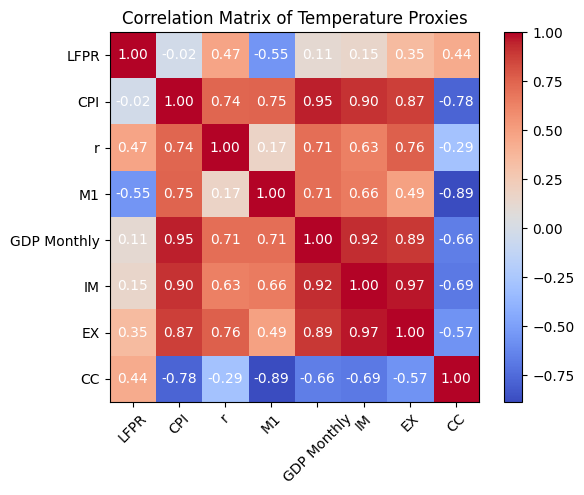

In [15]:
# plot correlation matrix for the original data
Cor_matrix = np.corrcoef(data)
plt.imshow(Cor_matrix)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.title('Correlation Matrix of Temperature Proxies')

for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{Cor_matrix[i, j]:.2f}',
                 ha='center', va='center', color='white')
plt.xticks(range(8), ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC'], rotation=45)
plt.yticks(range(8), ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC'])

plt.show()

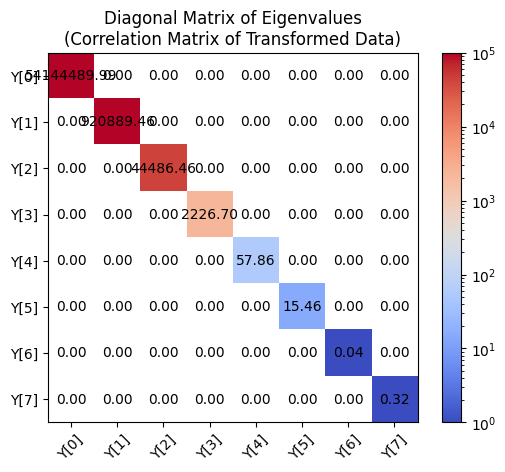

In [17]:
# plot the correlation matrix of the transformed data,
# which is the diagonal matrix of eigenvalues
from matplotlib.colors import LogNorm

plt.imshow(D, cmap='coolwarm', norm=LogNorm(vmin=1e0, vmax=1e5))
plt.colorbar()
plt.title('Diagonal Matrix of Eigenvalues' + "\n"  +
          '(Correlation Matrix of Transformed Data)')

for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{D[i, j]:.2f}',
                 ha='center', va='center', color='black')
plt.xticks(range(8), ['Y[0]', 'Y[1]', 'Y[2]', 'Y[3]', 'Y[4]', 'Y[5]', 'Y[6]', 'Y[7]'], rotation=45)
plt.yticks(range(8), ['Y[0]', 'Y[1]', 'Y[2]', 'Y[3]', 'Y[4]', 'Y[5]', 'Y[6]', 'Y[7]'])

plt.show()

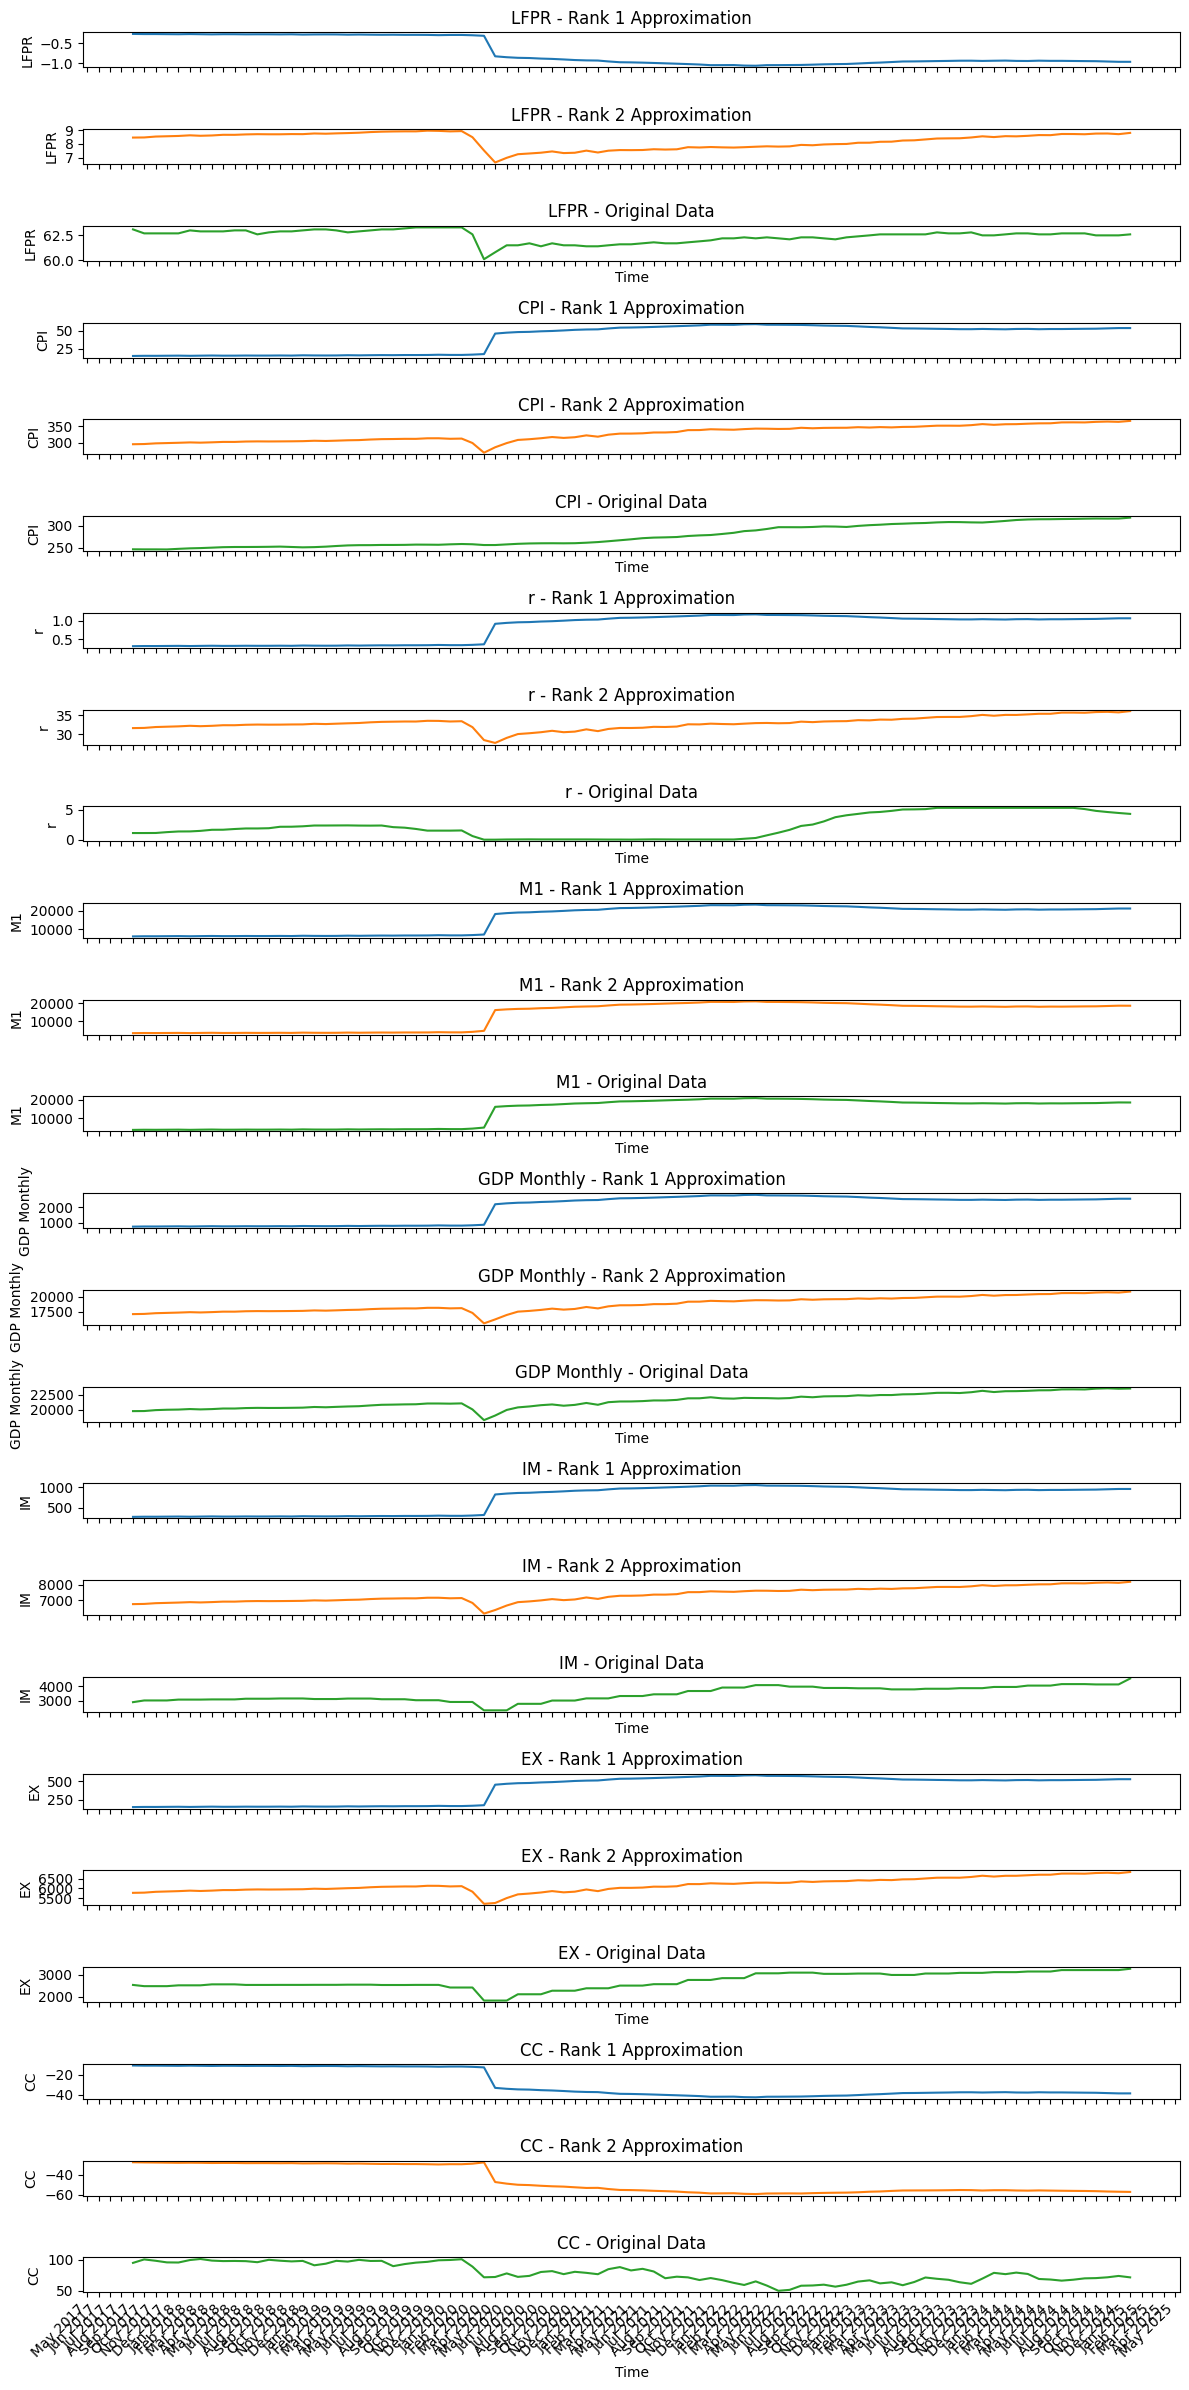

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

num_macros = len(macro_list)
fig, axs = plt.subplots(nrows=3 * num_macros, ncols=1, figsize=(12, 3 * num_macros), sharex=True)

for i, macro_name in enumerate(macro_list):
    macro_index = i

    approx1 = P[:, :1] @ transformed_data[:1, :]
    approx2 = P[:, :2] @ transformed_data[:2, :]

    original = data[macro_index]
    approx_1_series = approx1[macro_index]
    approx_2_series = approx2[macro_index]

    # Plot Rank 1 Approximation
    axs[3*i].plot(time_index, approx_1_series, color='tab:blue')
    axs[3*i].set_title(f'{macro_name} - Rank 1 Approximation')
    axs[3*i].set_ylabel(macro_name)
    axs[3*i].set_xticks([])

    # Plot Rank 2 Approximation
    axs[3*i + 1].plot(time_index, approx_2_series, color='tab:orange')
    axs[3*i + 1].set_title(f'{macro_name} - Rank 2 Approximation')
    axs[3*i + 1].set_ylabel(macro_name)
    axs[3*i + 1].set_xticks([])

    # Plot Original Data
    axs[3*i + 2].plot(time_index, original, color='tab:green')
    axs[3*i + 2].set_title(f'{macro_name} - Original Data')
    axs[3*i + 2].set_ylabel(macro_name)
    axs[3*i + 2].set_xlabel('Time')

    # Format x-axis on this bottom subplot to show months nicely
    axs[3*i + 2].xaxis.set_major_locator(mdates.MonthLocator())
    axs[3*i + 2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axs[3*i + 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Add new PC macros to sheet

In [22]:
# Step 1: Choose rank
k = 2

# Step 2: Truncate eigenvectors and scores
P_trunc = P[:, :k]                          # shape: (n_macros, 2)
transformed_trunc = transformed_data[:k, :]  # shape: (2, n_timepoints)

# Step 3: Transpose scores to get time series for PC1 and PC2
pcs = transformed_trunc.T  # shape: (n_timepoints, 2)

# Step 4: Create DataFrame with correct index
pc_df = pd.DataFrame(pcs, columns=['PC1_macro', 'PC2_macro'], index=df.index)

# Step 5: Add to your original sheet
df_augmented = pd.concat([df, pc_df], axis=1)

# Optional: overwrite original df if you want
# df = df_augmented

# Confirm
print(df_augmented.head())


             Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

            Cardano  USD Coin    VIX   MOVE  ...  vol_LFPR  vol_CPI  vol_r  \
2017-09-01      NaN       NaN  10.59  52.88  ...       NaN      NaN    NaN   
2017-10-01      NaN       NaN   9.51  51.15  ...       NaN      NaN    NaN   
2017-11-01      NaN       NaN  10.18  46.83  ...       NaN      NaN    NaN   
2017-12-01      NaN       NaN  11.28  46.60  ...       NaN      NaN    NaN   
2018-01-01      NaN       NaN  11.04  57.20  ...       NaN      NaN    NaN   

            vol_M1  vol_GDP  vol_IM  vol_EX  vol_CC    PC1_macro     PC2_macro  
2017-09-01 